In [1]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import cPickle as pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.misc import imread
from scipy.misc import imresize
from scipy.io import loadmat
from scipy.interpolate import spline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Input, ZeroPadding2D,merge,Lambda
from keras.layers.convolutional import Convolution2D
from keras.models import Model
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.optimizers import SGD
from keras import backend as K
from keras.engine import Layer
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from keras.layers.core import  Lambda
from keras.regularizers import l2
#}

Using Theano backend.


In [2]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [3]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        img = imread(im_path, mode='RGB')
        #print im_path
        #print img.shape
        if img_size:
            img = imresize(img, img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        if color_mode == 'bgr':
            img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]
        img = img.transpose((2, 0, 1))

        if crop_size:
            img = img[:, (img_size[0] - crop_size[0]) // 2:(img_size[0] + crop_size[0]) // 2
            , (img_size[1] - crop_size[1]) // 2:(img_size[1] + crop_size[1]) // 2]

        img_list.append(img)

    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print im_path
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [4]:
#Helper function to normalization across channels
K.set_image_dim_ordering('th')
def crosschannelnormalization(alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
    """
    This is the function used for cross channel normalization in the original
    Alexnet
    """
    def f(X):
        if K.image_dim_ordering()=='tf':
            b, r, c, ch = X.get_shape()
        else:
            b, ch, r, c = X.shape

        half = n // 2
        square = K.square(X)
        scale = k
        if K.image_dim_ordering() == 'th':
            extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 2, 3, 1)), ((0,0),(half,half)))
            extra_channels = K.permute_dimensions(extra_channels, (0, 3, 1, 2))
            for i in range(n):
                scale += alpha * extra_channels[:, i:i+ch, :, :]
        if K.image_dim_ordering() == 'tf':
            extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 3, 1, 2)), (half, 0))
            extra_channels = K.permute_dimensions(extra_channels, (0, 2, 3, 1))
            for i in range(n):
                scale += alpha * extra_channels[:, :, :, i:i+int(ch)]
        scale = scale ** beta
        return X / scale


    return Lambda(f, output_shape=lambda input_shape: input_shape, **kwargs)

In [5]:
#Helper Function to split tensor
def splittensor(axis=1, ratio_split=1, id_split=0, **kwargs):
    def f(X):
        div = K.shape(X)[axis] // ratio_split

        if axis == 0:
            output = X[id_split*div:(id_split+1)*div, :, :, :]
        elif axis == 1:
            output = X[:, id_split*div:(id_split+1)*div, :, :]
        elif axis == 2:
            output = X[:, :, id_split*div:(id_split+1)*div, :]
        elif axis == 3:
            output = X[:, :, :, id_split*div:(id_split+1)*div]
        else:
            raise ValueError("This axis is not possible")
        return output

    def g(input_shape):
        output_shape = list(input_shape)
        output_shape[axis] = output_shape[axis] // ratio_split
        return tuple(output_shape)


    return Lambda(f, output_shape=lambda input_shape: g(input_shape), **kwargs)

In [6]:
#Alexnet layer architecture class
def AlexNet(img_shape=(3, 227, 227), n_classes=1000, l2_reg=0.,weights_path=None, lambda_mask=None):

    dim_ordering = K.image_dim_ordering()
    print dim_ordering
    if dim_ordering == 'th':
        batch_index = 0
        channel_index = 1
        row_index = 2
        col_index = 3
    if dim_ordering == 'tf':
        batch_index = 0
        channel_index = 3
        row_index = 1
        col_index = 2
        
    
    inputs = Input(img_shape)

    conv_1 = Convolution2D(96, 11, 11, subsample=(4, 4), activation='relu',
                           name='conv_1', W_regularizer=l2(l2_reg))(inputs)

    if lambda_mask is not None:
        conv_1_mask  = np.reshape(lambda_mask[0:290400], (96,55,55))
    else:
        conv_1_mask = np.ones(shape=((96, 55, 55)))
    
    conv_1_mask  = K.variable(conv_1_mask)
    conv_1_lambda = Lambda(lambda x: x * conv_1_mask)(conv_1)

    conv_2 = MaxPooling2D((3, 3), strides=(2, 2))(conv_1_lambda)
    conv_2 = crosschannelnormalization(name="convpool_1")(conv_2)
    conv_2 = ZeroPadding2D((2, 2))(conv_2)
    conv_2 = merge([
        Convolution2D(128, 5, 5, activation="relu", name='conv_2_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_2)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_2")

    if lambda_mask is not None:
        conv_2_mask  = np.reshape(lambda_mask[290400:477024],(256, 27, 27) )
    else:
        conv_2_mask = np.ones(shape=((256, 27, 27)))
        
    conv_2_mask = K.variable(conv_2_mask)
    conv_2_lambda = Lambda(lambda x: x * conv_2_mask)(conv_2)

    conv_3 = MaxPooling2D((3, 3), strides=(2, 2))(conv_2_lambda)
    conv_3 = crosschannelnormalization()(conv_3)
    conv_3 = ZeroPadding2D((1, 1))(conv_3)
    conv_3 = Convolution2D(384, 3, 3, activation='relu', name='conv_3',
                           W_regularizer=l2(l2_reg))(conv_3)

    if lambda_mask is not None:
        conv_3_mask  = np.reshape(lambda_mask[477024:541920],(384, 13, 13))
    else:
        conv_3_mask = np.ones(shape=((384, 13, 13)))
    
    conv_3_mask = K.variable(conv_3_mask)
    conv_3_lambda = Lambda(lambda x: x * conv_3_mask)(conv_3)

    conv_4 = ZeroPadding2D((1, 1))(conv_3_lambda)
    conv_4 = merge([
        Convolution2D(192, 3, 3, activation="relu", name='conv_4_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_4)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_4")

    if lambda_mask is not None:
        conv_4_mask  = np.reshape(lambda_mask[541920:606816],(384, 13, 13))
    else:
        conv_4_mask = np.ones(shape=((384, 13, 13)))
        
    conv_4_mask = K.variable(conv_4_mask)
    conv_4_lambda = Lambda(lambda x: x * conv_4_mask)(conv_4)

    conv_5 = ZeroPadding2D((1, 1))(conv_4_lambda)
    conv_5 = merge([
        Convolution2D(128, 3, 3, activation="relu", name='conv_5_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_5)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_5")

    if lambda_mask is not None:
        conv_5_mask  = np.reshape(lambda_mask[606816:650080],(256, 13, 13))
    else:
        conv_5_mask = np.ones(shape=((256, 13, 13)))
    
    conv_5_mask = K.variable(conv_5_mask)
    conv_5_lambda = Lambda(lambda x: x * conv_5_mask)(conv_5)

    dense_1 = MaxPooling2D((3, 3), strides=(2, 2), name="convpool_5")(conv_5_lambda)

    dense_1 = Flatten(name="flatten")(dense_1)
    dense_1 = Dense(4096, activation='relu', name='dense_1',
                    W_regularizer=l2(l2_reg))(dense_1)

    if lambda_mask is not None:
        dense_1_mask  = np.reshape(lambda_mask[650080:654176],(4096,))
    else:
        dense_1_mask = np.ones(shape=((4096,)))
    
    
    dense_1_mask = K.variable(dense_1_mask)
    dense_1_lambda = Lambda(lambda x: x * dense_1_mask)(dense_1)

    dense_2 = Dropout(0.5)(dense_1_lambda)
    dense_2 = Dense(4096, activation='relu', name='dense_2',
                    W_regularizer=l2(l2_reg))(dense_2)

    if lambda_mask is not None:
        dense_2_mask  = np.reshape(lambda_mask[654176:658272],(4096,))
    else:
        dense_2_mask = np.ones(shape=((4096,)))
    
    dense_2_mask = K.variable(dense_2_mask)
    dense_2_lambda = Lambda(lambda x: x * dense_2_mask)(dense_2)

    dense_3 = Dropout(0.5)(dense_2_lambda)
    if n_classes == 1000:
        dense_3 = Dense(n_classes, name='dense_3',
                        W_regularizer=l2(l2_reg))(dense_3)

    else:
        # We change the name so when loading the weights_file from a
        # Imagenet pretrained model does not crash
        dense_3 = Dense(n_classes, name='dense_3_new',
                        W_regularizer=l2(l2_reg))(dense_3)

    prediction = Activation("softmax", name="softmax")(dense_3)

    model = Model(input=inputs, output=prediction)
    if weights_path:
        model.load_weights(weights_path)

    return model

In [7]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids


In [8]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print '##########', ind_
            pass
        line_num += 1
#}

In [9]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error


In [10]:
%%time
#Test Cell 1
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

data_path = '../../data/pkl/'
classes = ['animate','inanimate']
fold = 1

with open(data_path+classes[0]+'_fold_'+str(fold)+'_train.pkl') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_fold_'+str(fold)+'_train.pkl') as f:
        y_fold = pickle.load(f)
    
X = np.column_stack((X_fold,y_fold))
kmeans = MiniBatchKMeans(n_clusters=65827,
                         random_state=0,
                         batch_size=6,
                         max_iter=10).fit(X)
kmeans.cluster_centers_
pred_kmeans = kmeans.predict(X)
X_new = kmeans.cluster_centers_

CPU times: user 5h 40min 32s, sys: 2min 9s, total: 5h 42min 42s
Wall time: 1h 25min 42s


In [20]:
%%time
#Test Cell 2
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
result= {}   

j=14
clf_result = {}
clf_result[j] = {}
#clf = KMeans(n_clusters=j, random_state=143)
#clf =  AgglomerativeClustering(n_clusters=j, linkage='ward')
clf = Birch(branching_factor=50, n_clusters=j, threshold=0.5,compute_labels=True)
#clf = GaussianMixture(n_components=j, covariance_type='full',random_state=143)
y_pred = clf.fit_predict(X_new)


for label in set(clf.labels_):
    print('Cluster: ',j,'Label: ', label)

    #Lesioning and measuring performance
    pred = clf.predict(X_new)
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)
 
    lambda_mask = np.ones(shape=((658272,)))
    lambda_mask[loc_new] = 0.

    #plt.scatter(X[:,0],X[:,1], c=y_pred) 

    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
    model.compile(optimizer=sgd, loss='mse')

    flag = 0
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/pkl/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
        with open(image_list_valid,'rb') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(227,227), color_mode="rgb")
        out = model.predict(im_temp,batch_size=64)

        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)

        if flag == 0:
            dprime = error
            flag = 1
        else:
            dprime -= error

    result[label] = dprime
    #clf_result[j][label] = dprime
    
#with open('../../data/pkl/30_scree_fold_'+str(fold)+'.pickle', 'wb') as handle:
#    pickle.dump(clf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

#result[fold] = clf_result


('Cluster: ', 14, 'Label: ', 0)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 14, 'Label: ', 1)
th
animate 1 37 39 0.0512820512821
inanimate 1 34 39 0.128205128205
('Cluster: ', 14, 'Label: ', 2)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 14, 'Label: ', 3)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 14, 'Label: ', 4)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 14, 'Label: ', 5)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 14, 'Label: ', 6)
th
animate 1 38 39 0.025641025641
inanimate 1 34 39 0.128205128205
('Cluster: ', 14, 'Label: ', 7)
th
animate 1 34 39 0.128205128205
inanimate 1 7 39 0.820512820513
('Cluster: ', 14, 'Label: ', 8)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 14, 'Label: ', 9)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster:

In [10]:
%%time
#Version 1 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl/'
classes = ['animate','inanimate']


result= {}

k = 4 #Total Number of folds
fold = 1

for i in range(k):
    
    print('Perfoming Fold: ', fold)
    clf_result = {}
    
    with open(data_path+classes[0]+'_fold_'+str(fold)+'_train.pkl') as f:
        X_fold = pickle.load(f)
    with open(data_path+classes[1]+'_fold_'+str(fold)+'_train.pkl') as f:
        y_fold = pickle.load(f)
    
   
    
    X = np.column_stack((X_fold,y_fold))
    kmeans = MiniBatchKMeans(n_clusters=65827,
                             random_state=0,
                             batch_size=6,
                             max_iter=10).fit(X)
    kmeans.cluster_centers_
    pred_kmeans = kmeans.predict(X)
    X_new = kmeans.cluster_centers_
    
    
    #DO CLUSTERING AND GET CLUSTERS
    
    from sklearn.cluster import KMeans
    from sklearn.cluster import SpectralClustering
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.cluster import Birch
    from sklearn.mixture import GaussianMixture
    
    method ='Spectral'
    print(method)
    for j in range(1,51,1):
 
        clf_result[j] = {}
       
        print j

        # clf = KMeans(n_clusters=                                                                                                                                                                                                                                                                                                                                               clf= SpectralClustering(n_clusters=j, assign_labels="discretize",random_state=143)
        #clf =  AgglomerativeClustering(n_clusters=j, linkage='ward')
        #clf = Birch(branching_factor=50, n_clusters=j, threshold=0.5,compute_labels=True)
        #clf = GaussianMixture(n_components=j, covariance_type='full',random_state=143)
        y_pred = clf.fit_predict(X_new)
        #print clf.cluster_centers_

        for label in set(clf.labels_):
            print('Cluster: ',j,'Label: ', label)
            
            #Lesioning and measuring performance
            pred = clf.predict(X_new)
            loc = np.where(pred==label)
            loc_temp = kmeans.predict(X_new[loc[0]])
            loc_new =[]
            for entry in set(loc_temp):
                temp = np.where(pred_kmeans==entry)[0]
                loc_new.extend(temp)

            lambda_mask = np.ones(shape=((658272,)))
            lambda_mask[loc_new] = 0.

            #plt.scatter(X[:,0],X[:,1], c=y_pred) 

            sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
            model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
            model.compile(optimizer=sgd, loss='mse')
            
            flag = 0
            dprime = 0.
            for p in classes:
                im_valid_test = []
                image_list_valid = '../../data/pkl/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
                with open(image_list_valid,'rb') as f:
                    for line in f.readlines():
                        im_valid_test.append(line.strip('\n'))
                im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(227,227), color_mode="rgb")
                out = model.predict(im_temp,batch_size=64)

                true_valid_wids = []
                for i in im_valid_test:
                        temp1 = i.split('/')[4]
                        temp = temp1.split('.')[0].split('_')[2]
                        true_valid_wids.append(truth[int(temp)][1])

                predicted_valid_wids = []
                for i in range(len(im_valid_test)):
                    #print im_list[i], pprint_output(out[i]), true_wids[i]
                    predicted_valid_wids.append(pprint_output(out[i]))

                count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

                print str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)
                
                if flag == 0:
                    dprime = error
                    flag = 1
                else:
                    dprime -= error
                    
            clf_result[j][label] = dprime
    
    with open('../../data/pkl/'+str(method)+'_50_scree_fold_'+str(fold)+'.pickle', 'wb') as handle:
        pickle.dump(clf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    result[fold] = clf_result
    fold += 1
#}

('Perfoming Fold: ', 1)
 Ward
1


MemoryError: 

In [ ]:
result

In [ ]:
'''
#Version 2 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl/'
classes = ['animate','inanimate']


result= {}

k = 4 #Total Number of folds
fold = 1

for i in range(k):
    
    print('Perfoming Fold: ', fold)
    clf_result = {}
    
    with open(data_path+classes[0]+'_fold_'+str(fold)+'_train.pkl') as f:
        X_fold = pickle.load(f)
    with open(data_path+classes[1]+'_fold_'+str(fold)+'_train.pkl') as f:
        y_fold = pickle.load(f)
    
   
    
    X = np.column_stack((X_fold,y_fold))
    
    
    #DO CLUSTERING AND GET CLUSTERS
    
    from sklearn.cluster import KMeans
    
    for j in range(1,101,1):
        clf_result[j] = {}
        print j
        clf = KMeans(n_clusters=j, random_state=143)
        y_pred = clf.fit_predict(X)
        #print clf.cluster_centers_

        for label in set(clf.labels_):
            print('Cluster: ',j,'Label: ', label)
            
          
            #Lesioning and measuring performance
            pred = clf.predict(X)

            loc = np.where(pred==label)
            lambda_mask = np.ones(shape=((659272,)))
            lambda_mask[loc] = 0.

            #plt.scatter(X[:,0],X[:,1], c=y_pred) 

            sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
            model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
            model.compile(optimizer=sgd, loss='mse')
            
            flag = 0
            dprime = 0.
            for p in classes:
                im_valid_test = []
                image_list_valid = '../../data/pkl/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
                with open(image_list_valid,'rb') as f:
                    for line in f.readlines():
                        im_valid_test.append(line.strip('\n'))
                im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(227,227), color_mode="rgb")
                out = model.predict(im_temp,batch_size=64)

                true_valid_wids = []
                for i in im_valid_test:
                        temp1 = i.split('/')[4]
                        temp = temp1.split('.')[0].split('_')[2]
                        true_valid_wids.append(truth[int(temp)][1])

                predicted_valid_wids = []
                for i in range(len(im_valid_test)):
                    #print im_list[i], pprint_output(out[i]), true_wids[i]
                    predicted_valid_wids.append(pprint_output(out[i]))

                count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

                print str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)
                
                if flag == 0:
                    with open('../../data/animate_no_lesion_performance.txt','r') as f:
                        tmp = f.readlines()[fold-1]
                        cnt = int(tmp.split(' ')[2])
                
                    dprime = float(count) / cnt
                    flag = 1
                elif flag == 1:
                    with open('../../data/inanimate_no_lesion_performance.txt','r') as f:
                        tmp = f.readlines()[fold-1]
                        cnt = int(tmp.split(' ')[2])
                    dprime -= float(count) / cnt
                    
            clf_result[j][label] = dprime
    
    result[fold] = clf_result
    fold += 1
#}
'''

In [ ]:
result[1]

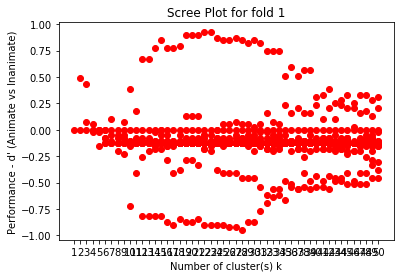

In [35]:
f = 1
clf_result = result[f]


plt.figure(1)
X = range(1,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance - d' (Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.savefig('../../results/scree/results_fold_'+str(f)+'.svg', format='svg', dpi=1200)

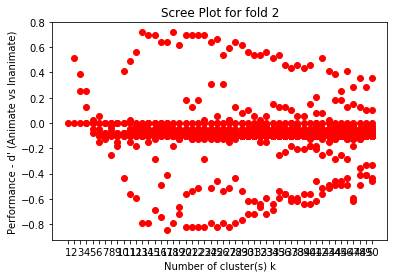

In [36]:
f = 2
clf_result = result[f]


plt.figure(1)
X = range(1,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance - d' (Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.savefig('../../results/scree/results_fold_'+str(f)+'.svg', format='svg', dpi=1200)

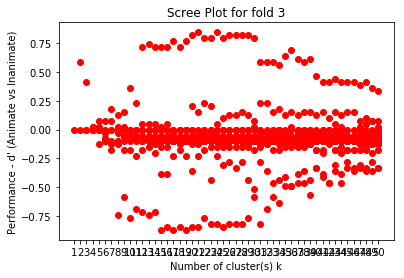

In [37]:
f = 3
clf_result = result[f]


plt.figure(1)
X = range(1,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance - d' (Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.savefig('../../results/scree/results_fold_'+str(f)+'.svg', format='svg', dpi=1200)

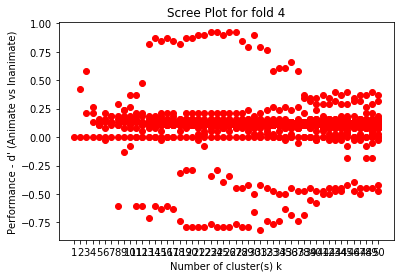

In [38]:
f = 4
clf_result = result[f]


plt.figure(1)
X = range(1,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance - d' (Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.savefig('../../results/scree/results_fold_'+str(f)+'.svg', format='svg', dpi=1200)

In [27]:
#Loading the pickle files
k = 4
result ={}
for i in range(1,k+1,1):
    name = '../../data/pkl/KMeans_20_scree_fold_'+str(i)+'.pickle'   #CHANGE
    with open(name,"rb") as f:
        result[i] = pickle.load(f)

In [28]:
result

{1: {1: {0: 0.0},
  2: {0: 0.0, 1: 0.4871794871794872},
  3: {0: 0.0, 1: 0.07692307692307698, 2: 0.435897435897436},
  4: {0: 0.0, 1: 0.05128205128205121, 2: 0.0, 3: -0.02564102564102566},
  5: {0: 0.0,
   1: 0.0,
   2: -0.02564102564102566,
   3: 0.0,
   4: -0.15384615384615385},
  6: {0: 0.0,
   1: -0.1282051282051282,
   2: -0.1282051282051282,
   3: -0.07692307692307698,
   4: -0.07692307692307687,
   5: 0.0},
  7: {0: -0.1282051282051282,
   1: 0.0,
   2: -0.1282051282051282,
   3: -0.1282051282051282,
   4: -0.10256410256410253,
   5: -0.05128205128205121,
   6: 0.10256410256410242},
  8: {0: -0.20512820512820507,
   1: -0.05128205128205132,
   2: -0.1282051282051282,
   3: -0.07692307692307687,
   4: 0.0,
   5: -0.1282051282051282,
   6: -0.1282051282051282,
   7: -0.1282051282051282},
  9: {0: 0.07692307692307687,
   1: -0.1282051282051282,
   2: -0.1282051282051282,
   3: -0.07692307692307698,
   4: -0.23076923076923073,
   5: -0.10256410256410253,
   6: 0.0,
   7: -0.12820512

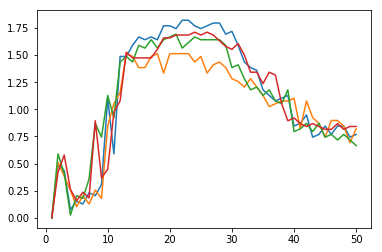

In [39]:
#Find MaxAd', MaxId' and its average
plt.figure()
noc = 4
for i in range(1,noc+1,1):
    X = []
    Y = []
    for j in range(1,51,1):
        X.append(j)
        temp = []
        for key, value in result[i][j].iteritems():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        avg = float(maxa - maxi)
        Y.append(avg)
    #print X,Y
    plt.plot(X,Y)

1.03002699055 21


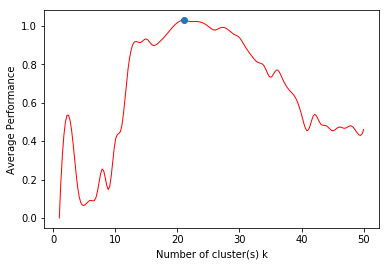

In [41]:
#Smooth average graph

noc = 4
flag = 0
X = range(1,51,1)
an_fold =[]
ian_fold = []
Y = []
for i in range(1,noc+1,1):
    if i == 2:
        flag = 1
    for j in range(1,51,1):
        temp = []
        for key, value in result[i][j].iteritems():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        if flag == 0:
            an_fold.append(maxa)
            ian_fold.append(maxi)
        else:
            an_fold[j-1] += maxa
            ian_fold[j-1] = maxi

for j in range(1,51,1):
    maxa = (an_fold[j-1]) / 4.
    maxi = (ian_fold[j-1]) /4.
    diff = maxa - maxi
    Y.append(diff)
    
x_sm = np.array(X)
y_sm = np.array(Y)

x_smooth = np.linspace(x_sm.min(), x_sm.max(), 200)
y_smooth = spline(X, Y, x_smooth)

plt.plot(x_smooth, y_smooth, 'r', linewidth=1)
plt.plot(Y.index(max(Y))+1,max(Y),'o')
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Average Performance")

print max(Y), Y.index(max(Y)) + 1